# Instead of always being admitted to hospital, dispostition decision is sampled from dataset

Setup

In [2]:
# Load libraries
library(simmer)
library(simmer.plot)
library(tidyverse)
library(tidymodels)

# Set seed for reproducibility
set.seed(42)

Loading required package: ggplot2


Attaching package: ‘simmer.plot’


The following objects are masked from ‘package:simmer’:

    get_mon_arrivals, get_mon_attributes, get_mon_resources


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.1.0     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::lag()          masks stats::lag()
✖ lubridate::now()      masks simmer::now()
✖ lubridate::rollback() masks simmer::rollback()
✖ dplyr::select()       masks simmer::select()
✖ tidyr::separate()     masks simmer::separate()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.4.1 ──

✔ broom        1.0.10     

In [3]:
# Load MIMIC-IV data

# Define data directory
# data_dir <- "~/Desktop/MIMIC_ED/processed/"
data_dir <- "../../../MIMIC_ED/processed/" 


# Load all four tables
ed_stays <- read_csv(paste0(data_dir, "ed_stays.csv"))
ed_activities <- read_csv(paste0(data_dir, "ed_activity_log.csv"))
ed_diagnoses <- read_csv(paste0(data_dir, "ed_diagnoses.csv"))
ed_medications <- read_csv(paste0(data_dir, "ed_medications.csv"))


# query medcount per stay
med_count_per_stay <- ed_medications %>%
  group_by(stay_id) %>%
  summarise(medication_count = n()) 

Rows: 425028 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): gender, race, arrival_transport, disposition, chiefcomplaint
dbl  (5): stay_id, subject_id, hadm_id, acuity, ed_los_hours
lgl  (1): is_admitted
dttm (3): arrival_time, triage_time, depart_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3737756 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): activity
dbl  (5): stay_id, subject_id, hadm_id, acuity, activity_seq
dttm (1): timestamps

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 898730 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): icd_code, icd_t


=== DATA QUALITY CHECKS ===
Inconsistent records (disposition=ADMITTED but is_admitted=FALSE): 0 

=== COHORT SUMMARY ===
Total ED visits: 425,028 
Admitted patients: 158,010 ( 37.2 %)

=== LOS DISTRIBUTION (Admitted Patients) ===
Minutes:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0   260.0   374.0   436.6   527.0 29584.2 

Hours:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.0167   4.3333   6.2333   7.2772   8.7833 493.0694 

=== TRANSFER THRESHOLD (for Phase 2) ===
80th percentile: 573 minutes ( 9.55 hours)


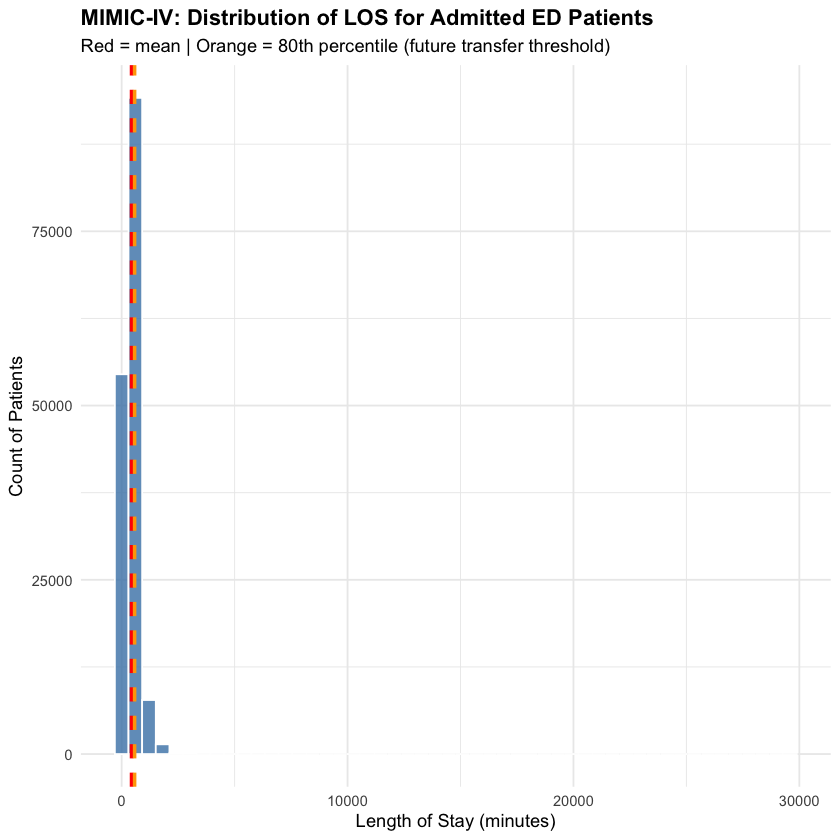

In [7]:
# DATA CLEANING FOR ED SIMULATION

# Filter for admitted patients only
ed_admitted <- ed_stays %>%
  filter(is_admitted == TRUE) %>%
  mutate(
    los_minutes = ed_los_hours * 60,
    los_minutes = if_else(is.na(los_minutes) | los_minutes <= 0, 
                          median(los_minutes, na.rm = TRUE), 
                          los_minutes)
  )

# Check for inconsistencies
inconsistencies <- ed_stays %>%
  filter(disposition == "ADMITTED" & is_admitted == FALSE) %>%
  nrow()

cat("\n=== DATA QUALITY CHECKS ===\n")
cat("Inconsistent records (disposition=ADMITTED but is_admitted=FALSE):", inconsistencies, "\n")

# Overall statistics
total_visits <- nrow(ed_stays)
total_admitted <- nrow(ed_admitted)
admission_rate <- round(100 * total_admitted / total_visits, 1)

cat("\n=== COHORT SUMMARY ===\n")
cat("Total ED visits:", format(total_visits, big.mark = ","), "\n")
cat("Admitted patients:", format(total_admitted, big.mark = ","), 
    "(", admission_rate, "%)\n")

# LOS distribution for admitted patients
cat("\n=== LOS DISTRIBUTION (Admitted Patients) ===\n")
cat("Minutes:\n")
print(summary(ed_admitted$los_minutes))
cat("\nHours:\n")
print(summary(ed_admitted$ed_los_hours))

# Calculate 80th percentile threshold
los_threshold_80 <- quantile(ed_admitted$los_minutes, 0.80, na.rm = TRUE)
cat("\n=== TRANSFER THRESHOLD (for Phase 2) ===\n")
cat("80th percentile:", round(los_threshold_80, 2), "minutes")
cat(" (", round(los_threshold_80/60, 2), "hours)\n")

# Visualize real MIMIC distribution
ggplot(ed_admitted, aes(x = los_minutes)) +
  geom_histogram(bins = 50, fill = "steelblue", color = "white", alpha = 0.8) +
  geom_vline(aes(xintercept = mean(los_minutes, na.rm = TRUE)), 
             color = "red", linetype = "dashed", linewidth = 1) +
  geom_vline(aes(xintercept = los_threshold_80), 
             color = "orange", linetype = "dashed", linewidth = 1) +
  labs(
    title = "MIMIC-IV: Distribution of LOS for Admitted ED Patients",
    subtitle = "Red = mean | Orange = 80th percentile (future transfer threshold)",
    x = "Length of Stay (minutes)",
    y = "Count of Patients"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold"))

Parameters

In [119]:
# function that simplifies race into 6 main categories (the model uses it so it needs to be defined here)
simplify_race <- function(r) {
  r <- toupper(as.character(r))
  
  if (grepl("WHITE", r)) {
    "WHITE"
  } else if (grepl("BLACK", r) || grepl("AFRICAN", r)) {
    "BLACK"
  } else if (grepl("HISPANIC", r) || grepl("LATINO", r)) {
    "HISPANIC"
  } else if (grepl("ASIAN", r)) {
    "ASIAN"
  } else if (grepl("NATIVE", r) || grepl("PACIFIC", r) || grepl("ALASKA", r)) {
    "NATIVE/PI"
  } else {
    "OTHER"
  }
}

simplify_race_vec <- function(r) {
  sapply(r, simplify_race)
}

# log_hosp_los_hours ~ acuity + race + gender + ed_los_hours + medication_count
mod <- readRDS("../models/model_v1.rds")


In [121]:
# Resource capacities (start with infinite as Karandeep suggested)
ED_BED_CAPACITY <- Inf

# Time distributions using MIMIC IV data
los_time <- function() sample(ed_admitted$los_minutes, 1)



# Arrival rate (placeholder, used Karandeep's code ~3.33 patients per hour)
arrival_interval <- function() rexp(1, 1/(18/60))

# Store the transfer threshold for Phase 2
LOS_TRANSFER_THRESHOLD <- los_threshold_80

cat("   - LOS: Sampling from", format(nrow(ed_admitted), big.mark = ","), 
    "admitted patient records\n")
cat("   - Mean LOS:", round(mean(ed_admitted$los_minutes), 1), "minutes",
    "(", round(mean(ed_admitted$los_minutes)/60, 2), "hours)\n")
cat("   - Transfer threshold:", round(LOS_TRANSFER_THRESHOLD, 1), "minutes",
    "(", round(LOS_TRANSFER_THRESHOLD/60, 2), "hours)\n")

   - LOS: Sampling from 158,010 admitted patient records
   - Mean LOS: 436.6 minutes ( 7.28 hours)
   - Transfer threshold: 573 minutes ( 9.55 hours)


Patient Trajectory

In [132]:

# Define patient flow through ED
patient_trajectory <- trajectory("ED patient flow") %>%
  seize("ed_bed", 1) %>%              # Patient occupies ED bed
  timeout(los_time) %>%               # Stay for length of stay
  release("ed_bed", 1) %>%               # Leave ED (disposition)

# Predict hospital LOS and store it
  log_(function() {
    patient_counter <<- patient_counter + 1  # increment patient ID
    
    # Sample predictors
    new_patient <- tibble(
      acuity = sample(ed_stays$acuity, 1),
      race = sample(ed_stays$race, 1),
      gender = sample(ed_stays$gender, 1),
      ed_los_hours = sample(ed_stays$ed_los_hours, 1),
      medication_count = sample(med_count_per_stay$medication_count, 1)
    )
    
    # Predict hospital LOS
    pred_hours <- predict(mod, new_data = new_patient)$.pred %>% expm1()
    
    # Save to tibble
    hospital_los_log <<- bind_rows(
      hospital_los_log,
      tibble(patient_id = patient_counter, pred_hosp_los = pred_hours)
    )
    
    paste("predicted hospital LOS (hours):", round(pred_hours, 1))
    
  })

Build Sim Environment

In [133]:
# Create environment
ed_sim <- simmer("ED Simulation V1")

# Add resources
ed_sim %>%
  add_resource("ed_bed", capacity = ED_BED_CAPACITY)

# Add patient generator
ed_sim %>%
  add_generator("patient", patient_trajectory, arrival_interval, mon = 2)

simmer environment: ED Simulation V1 | now: 0 | next: 
{ Monitor: in memory }
{ Resource: ed_bed | monitored: TRUE | server status: 0(Inf) | queue status: 0(Inf) }

simmer environment: ED Simulation V1 | now: 0 | next: 0
{ Monitor: in memory }
{ Resource: ed_bed | monitored: TRUE | server status: 0(Inf) | queue status: 0(Inf) }
{ Source: patient | monitored: 2 | n_generated: 0 }

Run Sim

In [134]:
# Create an empty tibble to store results for predicted LOS
hospital_los_log <- tibble(patient_id = integer(), pred_hosp_los = numeric())

# Counter for patient IDs
# patient_counter <- 0

# Run for 24 hours (1440 minutes)
ed_sim %>% run(until = 1440)

# Check final time
simmer::now(ed_sim)

104.815: patient223: predicted hospital LOS (hours): 66.4
122.718: patient12: predicted hospital LOS (hours): 73.4
125.967: patient5: predicted hospital LOS (hours): 48.6
131.633: patient213: predicted hospital LOS (hours): 10.3
134.151: patient140: predicted hospital LOS (hours): 45.5
141.099: patient151: predicted hospital LOS (hours): 87.5
145.604: patient220: predicted hospital LOS (hours): 25.2
160.723: patient25: predicted hospital LOS (hours): 34.1
161.229: patient94: predicted hospital LOS (hours): 44.3
161.427: patient10: predicted hospital LOS (hours): 243.9
161.495: patient4: predicted hospital LOS (hours): 33.6
162.837: patient72: predicted hospital LOS (hours): 42
166.441: patient197: predicted hospital LOS (hours): 65.5
174.638: patient31: predicted hospital LOS (hours): 59.1
177.615: patient379: predicted hospital LOS (hours): 79
178.48: patient124: predicted hospital LOS (hours): 36.5
180.74: patient201: predicted hospital LOS (hours): 83.5
181.194: patient142: predicte

simmer environment: ED Simulation V1 | now: 1440 | next: 1440.04827605435
{ Monitor: in memory }
{ Resource: ed_bed | monitored: TRUE | server status: 1406(Inf) | queue status: 0(Inf) }
{ Source: patient | monitored: 2 | n_generated: 4684 }

[1] 1440

Extract Results

In [102]:
# Get monitoring data
arrivals <- get_mon_arrivals(ed_sim)
resources <- get_mon_resources(ed_sim)

# Quick summary
summary(arrivals$activity_time)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  18.78  236.00  333.50  365.36  464.00 1297.03 

In [106]:
# predicted hosp LOS
head(hospital_los_log)

patient_id,pred_hosp_los
<dbl>,<dbl>
1,72.50734
2,49.73247
3,63.37629
4,24.47674
5,79.72897
6,82.77594


Visualizations

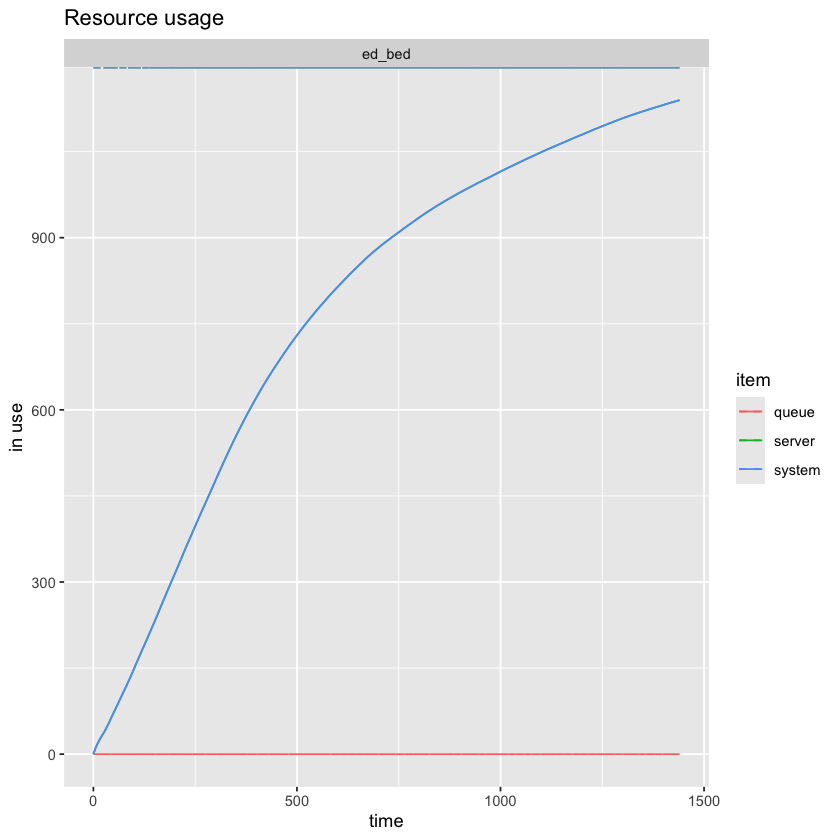

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


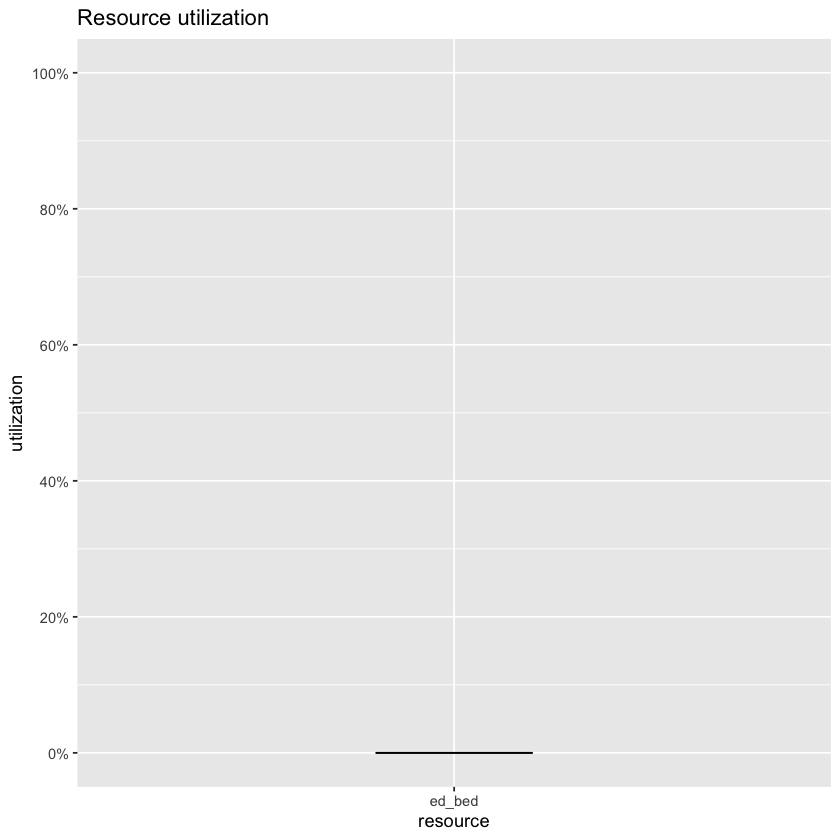

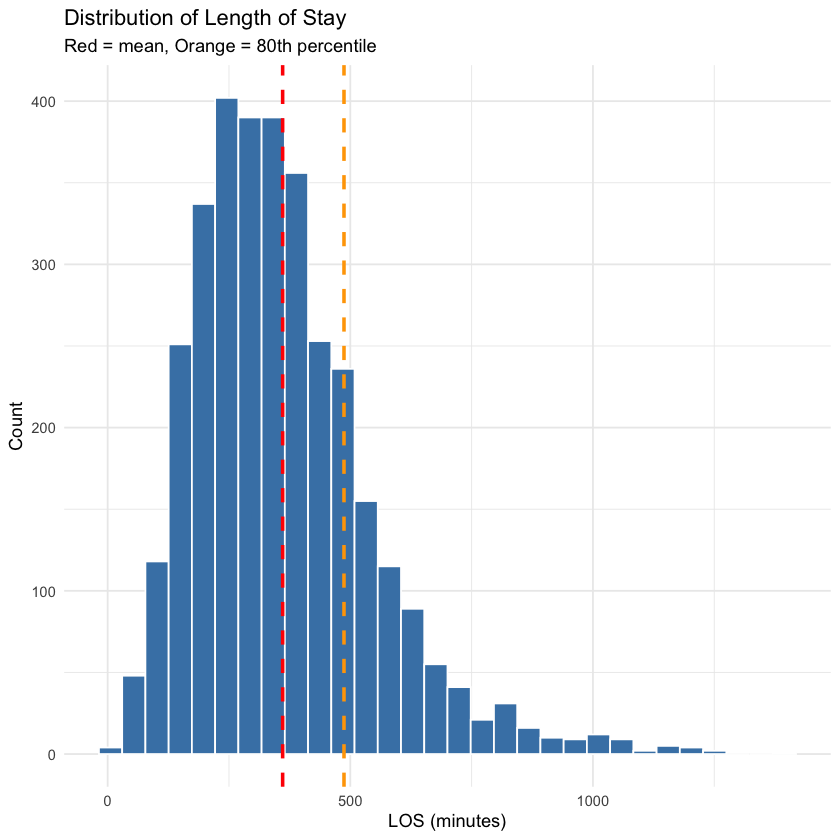

In [13]:
# Plot resource usage over time
plot(resources, metric = "usage")

# Plot resource utilization
plot(resources, metric = "utilization")

# Histogram of length of stay
ggplot(arrivals, aes(x = activity_time)) +
  geom_histogram(bins = 30, fill = "steelblue", color = "white") +
  geom_vline(aes(xintercept = mean(activity_time)), 
             color = "red", linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = quantile(activity_time, 0.80)), 
             color = "orange", linetype = "dashed", size = 1) +
  labs(
    title = "Distribution of Length of Stay",
    subtitle = "Red = mean, Orange = 80th percentile",
    x = "LOS (minutes)",
    y = "Count"
  ) +
  theme_minimal()